Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [2]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()): #type: ignore
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = True #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive #type: ignore
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [3]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [4]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [ ]:
from pprint import pprint
import dataclasses
pprint(dataclasses.asdict(vehicle_provider.next()))

### Game config

In [5]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=30 #@param {type:"integer"}
    ,
    cycle_every=5 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=3 #@param {type:"integer"}
)

### Attacker agent config

In [6]:
from agents import AttackerAgent, PassiveAgent, BasicAttackerAgent
from game import State

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  def get_attacker_utility(self:AttackerAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members for vuln in v.vulnerabilities]
    return len(comp)

  attacker = BasicAttackerAgent(
    attack_limit=1 #@param {type:"integer"}
    ,
    attack_interval=5 #@param {type:"integer"},
    ,
    utility_func=get_attacker_utility
  )
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [7]:
from agents import WolpertingerDefenderAgent
from models import StateShapeData
from vehicles import CompromiseState, Vehicle, Vulnerability

# def get_utility(self:WolpertingerDefenderAgent, state: State) -> float:
#     members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
#     compromises = sum([vuln.severity ** 2 for vehicle in members for vuln in vehicle.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED])
#     return len(members) * 2.5 - compromises


def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
    return 100 - sum([
        vuln.severity for vehicle in state.vehicles
        if vehicle.in_platoon
        for vuln in vehicle.vulnerabilities
        if vuln.state != CompromiseState.NOT_COMPROMISED
    ])
    # members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    # compromises = sum([vuln.severity ** 2 for vehicle in members for vuln in vehicle.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED])
    # return len(members) * 2.5 - compromises


# def get_utility(self:WolpertingerDefenderAgent, state: State) -> float:
#     return sum([
#         -10/(vuln.severity)
#         for vehicle in state.vehicles if not vehicle.in_platoon
#         for vuln in vehicle.vulnerabilities
#         if vuln.state == CompromiseState.NOT_COMPROMISED
#     ]) - sum([
#         vuln.severity
#         for vehicle in state.vehicles if vehicle.in_platoon
#         for vuln in vehicle.vulnerabilities
#         if vuln.state != CompromiseState.NOT_COMPROMISED
#     ])
    
load_checkpoint = False #@param {type:"boolean"}
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=3 #@param {type: "integer"}
    ,
    utility_func=get_defender_utility
)

if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Replay memory config

In [8]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=10000 #@param {type:"integer"}
)

### Training metrics tracker config

In [9]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Evaluation config

In [10]:
from evaluation import ModelEvaluator
evaluator = ModelEvaluator(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    memory=memory
)

## Baseline metrics

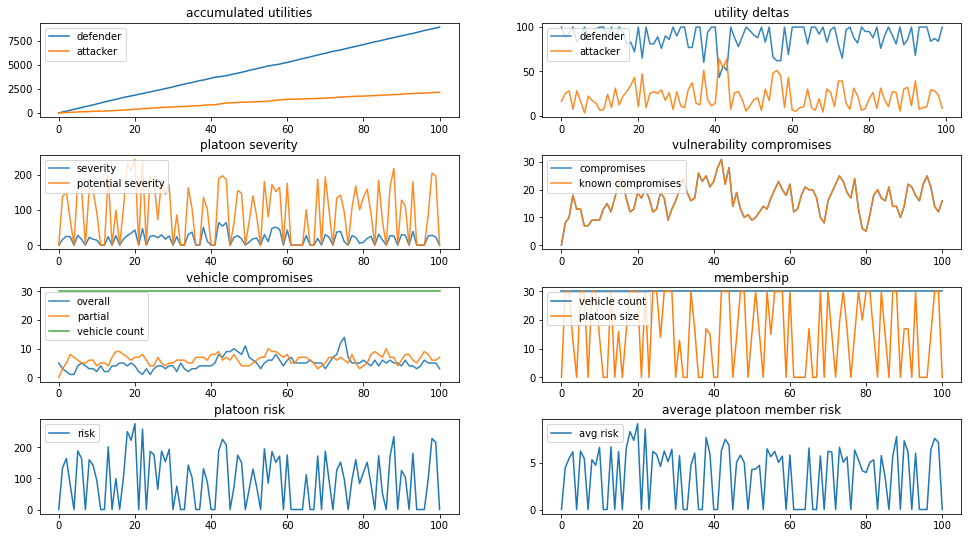

In [11]:
evaluator.get_episode_metrics(
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Trainer config

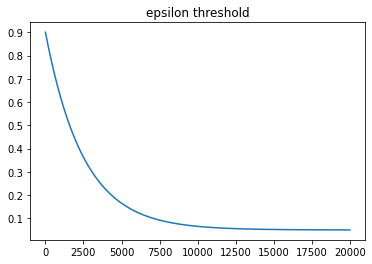

In [12]:
#@title Trainer
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=400 #@param {type:"integer"}
    ,
    train_steps=50 #@param {type:"integer"}
    ,
    train_interval=5 #@param {type:"integer"}
    ,
    warmup_replay=1000 #@param {type:"integer"}
    ,
    max_steps_per_episode=50 #@param {type:"integer"}
    ,
    update_policy_interval=10 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
    ,
    epsilon_start = 0.9 #@param {type:"number"}
    ,
    epsilon_end = 0.05 #@param {type:"number"}
    ,
    epsilon_decay = 2500 #@param {type:"number"}
    ,
))
trainer.plot_epsilon_threshold(num_steps=20000)

### Perform training

In [13]:
trainer.train()

Warming up...


  0%|          | 0/1000 [00:00<?, ?it/s]

Warmup complete~!


  0%|          | 0/50 [00:00<?, ?it/s]

2022-10-18 2322-16 041460 episode 21 step 0 optimizing loss=7267.1982 diff={max=100.1335, min=29.9899, mean=83.7892} policy_loss=-23.2043 policy updated! 
2022-10-18 2322-18 243557 episode 21 step 5 optimizing loss=3890.8396 diff={max=83.4660, min=5.0905, mean=60.0075} policy_loss=-68.6227 
2022-10-18 2322-20 123601 episode 21 step 10 optimizing loss=753.9029 diff={max=59.3508, min=0.0027, mean=23.5820} policy_loss=-146.2668 
2022-10-18 2322-22 016074 episode 21 step 15 optimizing loss=4302.5620 diff={max=160.9822, min=2.3219, mean=58.2035} policy_loss=-114.6283 
2022-10-18 2322-23 907598 episode 21 step 20 optimizing loss=1372.9838 diff={max=114.0062, min=0.0735, mean=29.7988} policy_loss=-78.2492 
2022-10-18 2322-25 822593 episode 21 step 25 optimizing loss=511.9512 diff={max=65.2127, min=0.0351, mean=18.8555} policy_loss=-55.5934 
2022-10-18 2322-27 723670 episode 21 step 30 optimizing loss=1115.3431 diff={max=64.5216, min=0.0088, mean=29.0734} policy_loss=-44.9701 
2022-10-18 2322-

KeyboardInterrupt: 

### View training metrics

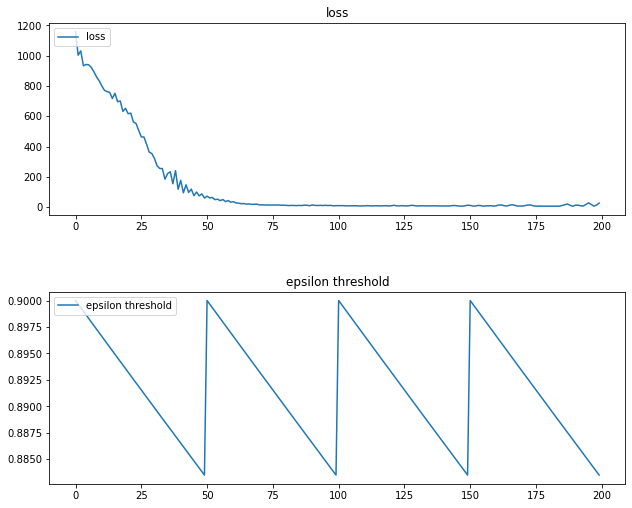

In [30]:
tracker.plot()
# limit scope to sub-1 loss
from itertools import takewhile
TrainingMetricsTracker(stats=list(takewhile(lambda entry: entry.optim.loss <= 1, tracker.stats[::-1]))[::-1]).plot()

## Evaluation

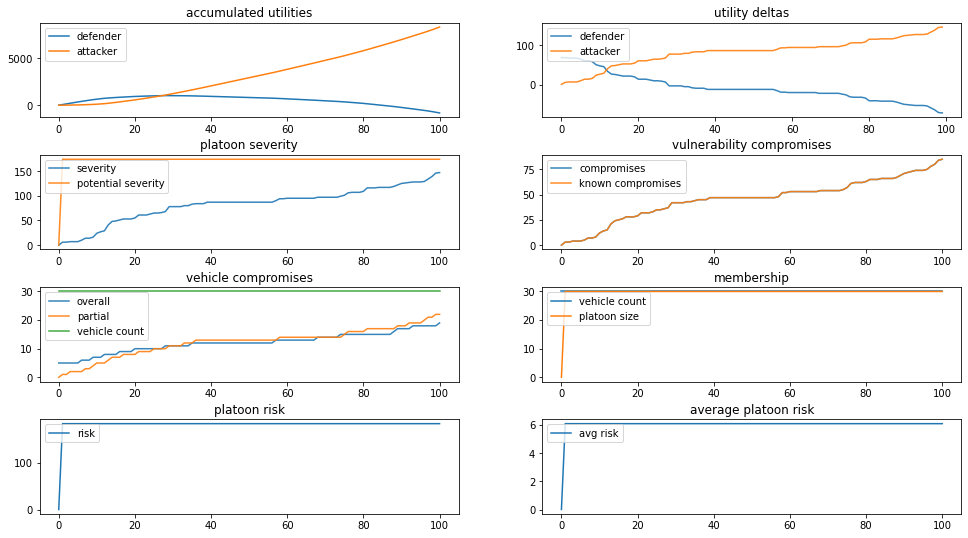

In [34]:
evaluator.get_episode_metrics(
    num_turns=100 #@param {type:"integer"}
).plot()

In [15]:
evaluator.sample_model_outputs()

action.members tensor([[1.8775e-25, 2.2620e-10, 7.4650e-23, 1.0000e+01, 2.6479e-27, 4.5342e-15,
         1.2685e-33, 1.0000e+01, 2.7526e-16, 1.7223e-18, 8.3992e-12, 1.3653e-30,
         5.9171e-25, 4.3497e-12, 6.5520e-26, 1.0000e+01, 2.2497e-21, 2.7756e-13,
         2.0873e-20, 1.1835e-32, 4.9318e-22, 1.0000e+01, 1.9962e-34, 9.8227e-35,
         1.6352e-25, 1.0000e+01, 7.2719e-13, 8.5065e-27, 1.0000e+01, 3.9362e-16]],
       grad_fn=<SumBackward1>)
q_pred tensor([ 7.6854,  5.4475, -6.9996, -6.9996,  4.3640, -6.9996,  1.9386,  4.6268,
         7.2915,  6.2195], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([  6.,   6., -18.,   0.,   6., -21.,  -2.,   3.,   6.,   2.])
pred reward err tensor([ 1.6854, -0.5525, 11.0004, -6.9996, -1.6360, 14.0004,  3.9386,  1.6268,
         1.2915,  4.2195], grad_fn=<SubBackward0>)


## Manually checkpoint model

In [12]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)